Setting up the imports

In [193]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from typing import Tuple, List

Setting up the device

In [194]:
device: str = 'cuda' if torch.cuda.is_available() else 'cpu'


Setting up the Cifar10 Dataset

In [195]:
transforms = torchvision.transforms
train_augmentations = transforms.Compose([transforms.RandomGrayscale(0.2),
                                          transforms.RandomHorizontalFlip(0.5),
                                          transforms.RandomVerticalFlip(0.2),
                                          transforms.RandomRotation(30),
                                          transforms.RandomAdjustSharpness(0.4),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                         ])

test_augmentations = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
                                       )
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_augmentations
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_augmentations
)

Files already downloaded and verified
Files already downloaded and verified


Setting up the DataLoader

In [196]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

Just a preview

In [197]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32])


The Convolutional Neural Network class

In [198]:
class ConvNet(nn.Module):
    def __init__(self, classes: int):
        super(ConvNet, self).__init__()
        self.convolution_layers = nn.Sequential(
             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # 64 x 32 x 32
             nn.BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),

             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 128 x 32 x 32
             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),

             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # 128 x 32 x 32
             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),

             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # 128 x 32 x 32
             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),


             nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False), # 128 x 16 x 16
             nn.Dropout2d(p=0.1),


             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # 128 x 16 x 16
             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),

             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # 128 x 16 x 16
             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),

             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # 256 x 16 x 16
             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),



             nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False), # 256 x 8 x 8
             nn.Dropout2d(p=0.1),


             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # 256 x 8 x 8
             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),


             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # 256 x 8 x 8
             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),


             nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False), # 256 x 4 x 4
             nn.Dropout2d(p=0.1),


             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # 512 x 4 x 4
             nn.BatchNorm2d(512, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),


             nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False), # 512 x 2 x 2
             nn.Dropout2d(p=0.1),


             nn.Conv2d(512, 2048, kernel_size=1, stride=1, padding=0), # 2048 x 2 x 2
             nn.BatchNorm2d(2048, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),


             nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0), # 256 x 2 x 2
             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
             nn.ReLU(inplace=True),


             nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False), # 256 x 1 x 1
             nn.Dropout2d(p=0.1)
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(256, 100),
            nn.Tanh(),
            nn.Linear(100, classes),
        )
    def forward(self, x):
        out = self.convolution_layers(x)
        out = out.view(-1, 256)
        out = self.fully_connected(out)
        return out

Define testing loop

In [199]:
@torch.no_grad()
def test(
        model: nn.Module,
        criterion: nn.CrossEntropyLoss,
        loader: torch.utils.data.DataLoader,
        device: torch.device
) -> Tuple[float, float]:
    model.eval()
    accuracy, test_loss = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        test_loss += criterion(y_hat, y).item() * x.shape[0]
        _, predicted = torch.max(y_hat, axis=1)
        accuracy += (predicted == y).sum().item()
    accuracy /= len(loader.dataset)
    test_loss /= len(loader.dataset)
    return accuracy, test_loss

Define training loop

In [200]:
def train(model: nn.Module,
          epochs: int,
          criterion: nn.CrossEntropyLoss,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          device: torch.device) -> None:
    train_losses = []
    test_accuracies = []
    test_losses = []
    test_accuracy_untrained, test_loss_untrained = test(model, criterion, test_loader, device)
    print(f'On untrained model, test set: acc={test_accuracy_untrained*100:.2f}, loss={test_loss_untrained:.4f}')

    for epoch in range(1, epochs + 1):
        model.train()
        running_train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            running_train_loss += loss.item() * x.shape[0]

            model.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(running_train_loss / len(train_loader.dataset))
        test_accuracy, test_loss = test(model, criterion, test_loader, device)
        print(f'Epoch {epoch}/{epochs}, train set: loss={train_losses[-1]:.4f}')
        print(f'Epoch {epoch}/{epochs}, test set: acc={test_accuracy*100:.2f}%, loss={test_loss:.4f}')
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    x_epochs = list(range(1, epochs+1))
    plt.title('Loss curves')
    plt.plot(x_epochs, train_losses, 'red', label='Train loss')
    plt.plot(x_epochs, test_losses, 'green', label='Test loss')
    plt.legend(loc='best')
    plt.show()

    plt.title('Test accuracy')
    plt.plot(x_epochs, test_accuracies)
    plt.show()

Define the model instance

In [201]:
model = ConvNet(10)
model.to(device)

ConvNet(
  (convolution_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout2d(p=0.1, inplace=False)
    (14): Conv2d(128, 128, kernel_size=(3, 3), 

Request summary

In [202]:
#from torchsummary import summary
#summary(model)

In [203]:
epochs = 50
lr = 0.00205
momentum = 0.875
weight_decay = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

On untrained model, test set: acc=10.00, loss=2.3047
Epoch 1/50, train set: loss=1.6710
Epoch 1/50, test set: acc=56.52%, loss=1.1984
Epoch 2/50, train set: loss=1.3485
Epoch 2/50, test set: acc=64.40%, loss=1.0016
Epoch 3/50, train set: loss=1.1868
Epoch 3/50, test set: acc=69.68%, loss=0.8707
Epoch 4/50, train set: loss=1.0848
Epoch 4/50, test set: acc=74.00%, loss=0.7551
Epoch 5/50, train set: loss=1.0102
Epoch 5/50, test set: acc=76.32%, loss=0.6847
Epoch 6/50, train set: loss=0.9568
Epoch 6/50, test set: acc=76.87%, loss=0.6583
Epoch 7/50, train set: loss=0.9101
Epoch 7/50, test set: acc=78.54%, loss=0.6246
Epoch 8/50, train set: loss=0.8741
Epoch 8/50, test set: acc=80.89%, loss=0.5746
Epoch 9/50, train set: loss=0.8381
Epoch 9/50, test set: acc=81.21%, loss=0.5564
Epoch 10/50, train set: loss=0.8054
Epoch 10/50, test set: acc=81.47%, loss=0.5372
Epoch 11/50, train set: loss=0.7842
Epoch 11/50, test set: acc=80.55%, loss=0.5677
Epoch 12/50, train set: loss=0.7590
Epoch 12/50, tes

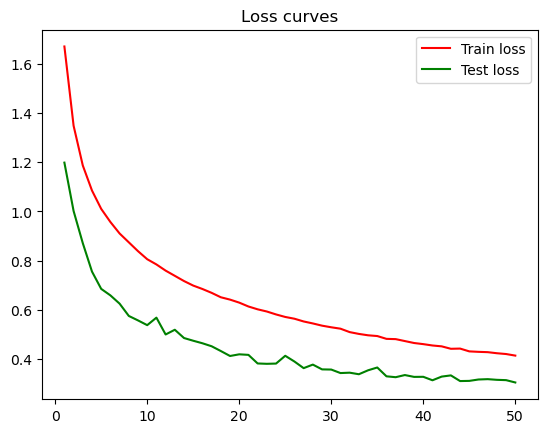

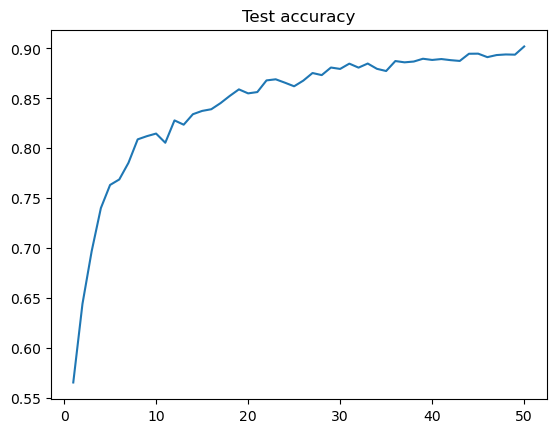

In [204]:
train(model, epochs, criterion, train_loader, test_loader, device)

layer 1, 2, 3, 128x3x3 + data augmentation
epochs = 100
lr = 0.00205
momentum = 0.86
weight_decay = 0.0011
80% accuracy